문제정의 : DecisionTreeClassifier를 사용하여 Breast Cancer 데이터 셋을 사용하여 유방암 양성(2), label -> 악성(4) 예측하기</br>
책에 없는 예제

기본 라이브러리 불러오기

In [1]:
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
import pandas as pd
import numpy as np

한글깨짐방지

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()


fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


step01 데이터 준비 - UCI ML Repository 제공하는 Breast Cancer 데이터셋 가져오기


In [3]:
# Breast Cancer 데이터셋 가져오기 (출처: UCI ML Repository)
uci_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/\
breast-cancer-wisconsin/breast-cancer-wisconsin.data'

df = pd.read_csv(uci_path, header=None)

In [4]:
# 열 이름 지정
df.columns = ['id', 'clump', 'cell_size', 'cell_shape', 'adhesion', 'epithlial',
              'bare_nuclei', 'chromatin', 'normal_nucleoli', 'mitoses', 'class']


step02 데이터 탐색 및 데이터 전처리

In [5]:
df.head()

,id,clump,cell_size,cell_shape,adhesion,epithlial,bare_nuclei,chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [6]:
# 데이터 자료형 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               699 non-null    int64 
 1   clump            699 non-null    int64 
 2   cell_size        699 non-null    int64 
 3   cell_shape       699 non-null    int64 
 4   adhesion         699 non-null    int64 
 5   epithlial        699 non-null    int64 
 6   bare_nuclei      699 non-null    object
 7   chromatin        699 non-null    int64 
 8   normal_nucleoli  699 non-null    int64 
 9   mitoses          699 non-null    int64 
 10  class            699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [7]:
# bare_nuclei 열의 자료형 변경하기(문자열 -> 숫자형)
# bare_nuclei 열의 고유 값을 확인하기 - '?'가 있음
print(df.bare_nuclei.unique())

['1' '10' '2' '4' '3' '9' '7' '?' '5' '8' '6']


In [8]:
# '?' 값을 nan으로 바꿈 -> nan을 dropna로 삭제 -> astype로 int형으로 변경
df.bare_nuclei.replace('?', np.nan, inplace=True)

In [9]:
# np.nan으로 변경된 값을 삭제하기
df.dropna(subset=['bare_nuclei'], axis=0, inplace=True)

In [10]:
df.bare_nuclei = df.bare_nuclei.astype('int')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               683 non-null    int64
 1   clump            683 non-null    int64
 2   cell_size        683 non-null    int64
 3   cell_shape       683 non-null    int64
 4   adhesion         683 non-null    int64
 5   epithlial        683 non-null    int64
 6   bare_nuclei      683 non-null    int64
 7   chromatin        683 non-null    int64
 8   normal_nucleoli  683 non-null    int64
 9   mitoses          683 non-null    int64
 10  class            683 non-null    int64
dtypes: int64(11)
memory usage: 64.0 KB


step03. 분석에 사용할 속성을 선택하기

In [12]:
# 속성(변수) 선택하기

X = df[['clump', 'cell_size', 'cell_shape', 'adhesion', 'epithlial',
       'bare_nuclei', 'chromatin', 'normal_nucleoli', 'mitoses']] # 설명 변수 X
y = df['class'] # 예측 변수 y

In [13]:
X

,clump,cell_size,cell_shape,adhesion,epithlial,bare_nuclei,chromatin,normal_nucleoli,mitoses
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1
...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1
695,2,1,1,1,2,1,1,1,1
696,5,10,10,3,7,3,8,10,2
697,4,8,6,4,3,4,10,6,1


In [14]:
# 설명 변수 데이터를 정규화하기

X = preprocessing.StandardScaler().fit(X).transform(X)

In [15]:
X

array([[ 0.19790469, -0.70221201, -0.74177362, ..., -0.18182716,
        -0.61292736, -0.34839971],
       [ 0.19790469,  0.27725185,  0.26278299, ..., -0.18182716,
        -0.28510482, -0.34839971],
       [-0.51164337, -0.70221201, -0.74177362, ..., -0.18182716,
        -0.61292736, -0.34839971],
       ...,
       [ 0.19790469,  2.23617957,  2.2718962 , ...,  1.86073779,
         2.33747554,  0.22916583],
       [-0.15686934,  1.58320366,  0.93248739, ...,  2.67776377,
         1.02618536, -0.34839971],
       [-0.15686934,  1.58320366,  1.6021918 , ...,  2.67776377,
         0.37054027, -0.34839971]])

step04. 데이터 셋 구분 - 훈련용(train data) / 검증용(test data)

In [16]:
# train data와 test data로 구분 (7: 3)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3, 
                                                    random_state= 0)

print(f'train data 개수: {X_train.shape}')
print(f'test data 개수: {X_test.shape}')

train data 개수: (478, 9)
test data 개수: (205, 9)


step05. Decision Tree 분류 모형 - sklearn 사용

In [39]:
# sklearn 라이브러리에서 Decision Tree 분류 모형 가져오기

# 모형 객체 생성 (최적의 속성을 찾기 위해  criterion='entropy' 적용) 
# * 적정한 레벨 값 찾는 것이 중요
tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)


In [40]:
# 훈련 데이터를 가지고 모형 학습하기
tree_model.fit(X_train, y_train)

# 테스트 데이터를 가지고 모델 예측하기
y_hat = tree_model.predict(X_test)
# 2번이 양성, 4번이 악성임



step06. 모델 성능 평가하기

In [41]:
print(f'훈련 세트 정확도: {tree_model.score(X_train, y_train) * 100}')
print(f'테스트 세트 정확도: {tree_model.score(X_test, y_test) * 100}')

훈련 세트 정확도: 97.28033472803347
테스트 세트 정확도: 95.1219512195122


In [31]:
# 모형 성능 평가 - 평가지표 계산

tree_report = metrics.classification_report(y_test, y_hat)
print(tree_report)

              precision    recall  f1-score   support

           2       0.95      0.98      0.96       130
           4       0.96      0.91      0.93        75

    accuracy                           0.95       205
   macro avg       0.95      0.94      0.95       205
weighted avg       0.95      0.95      0.95       205



DecisionTree 시각화

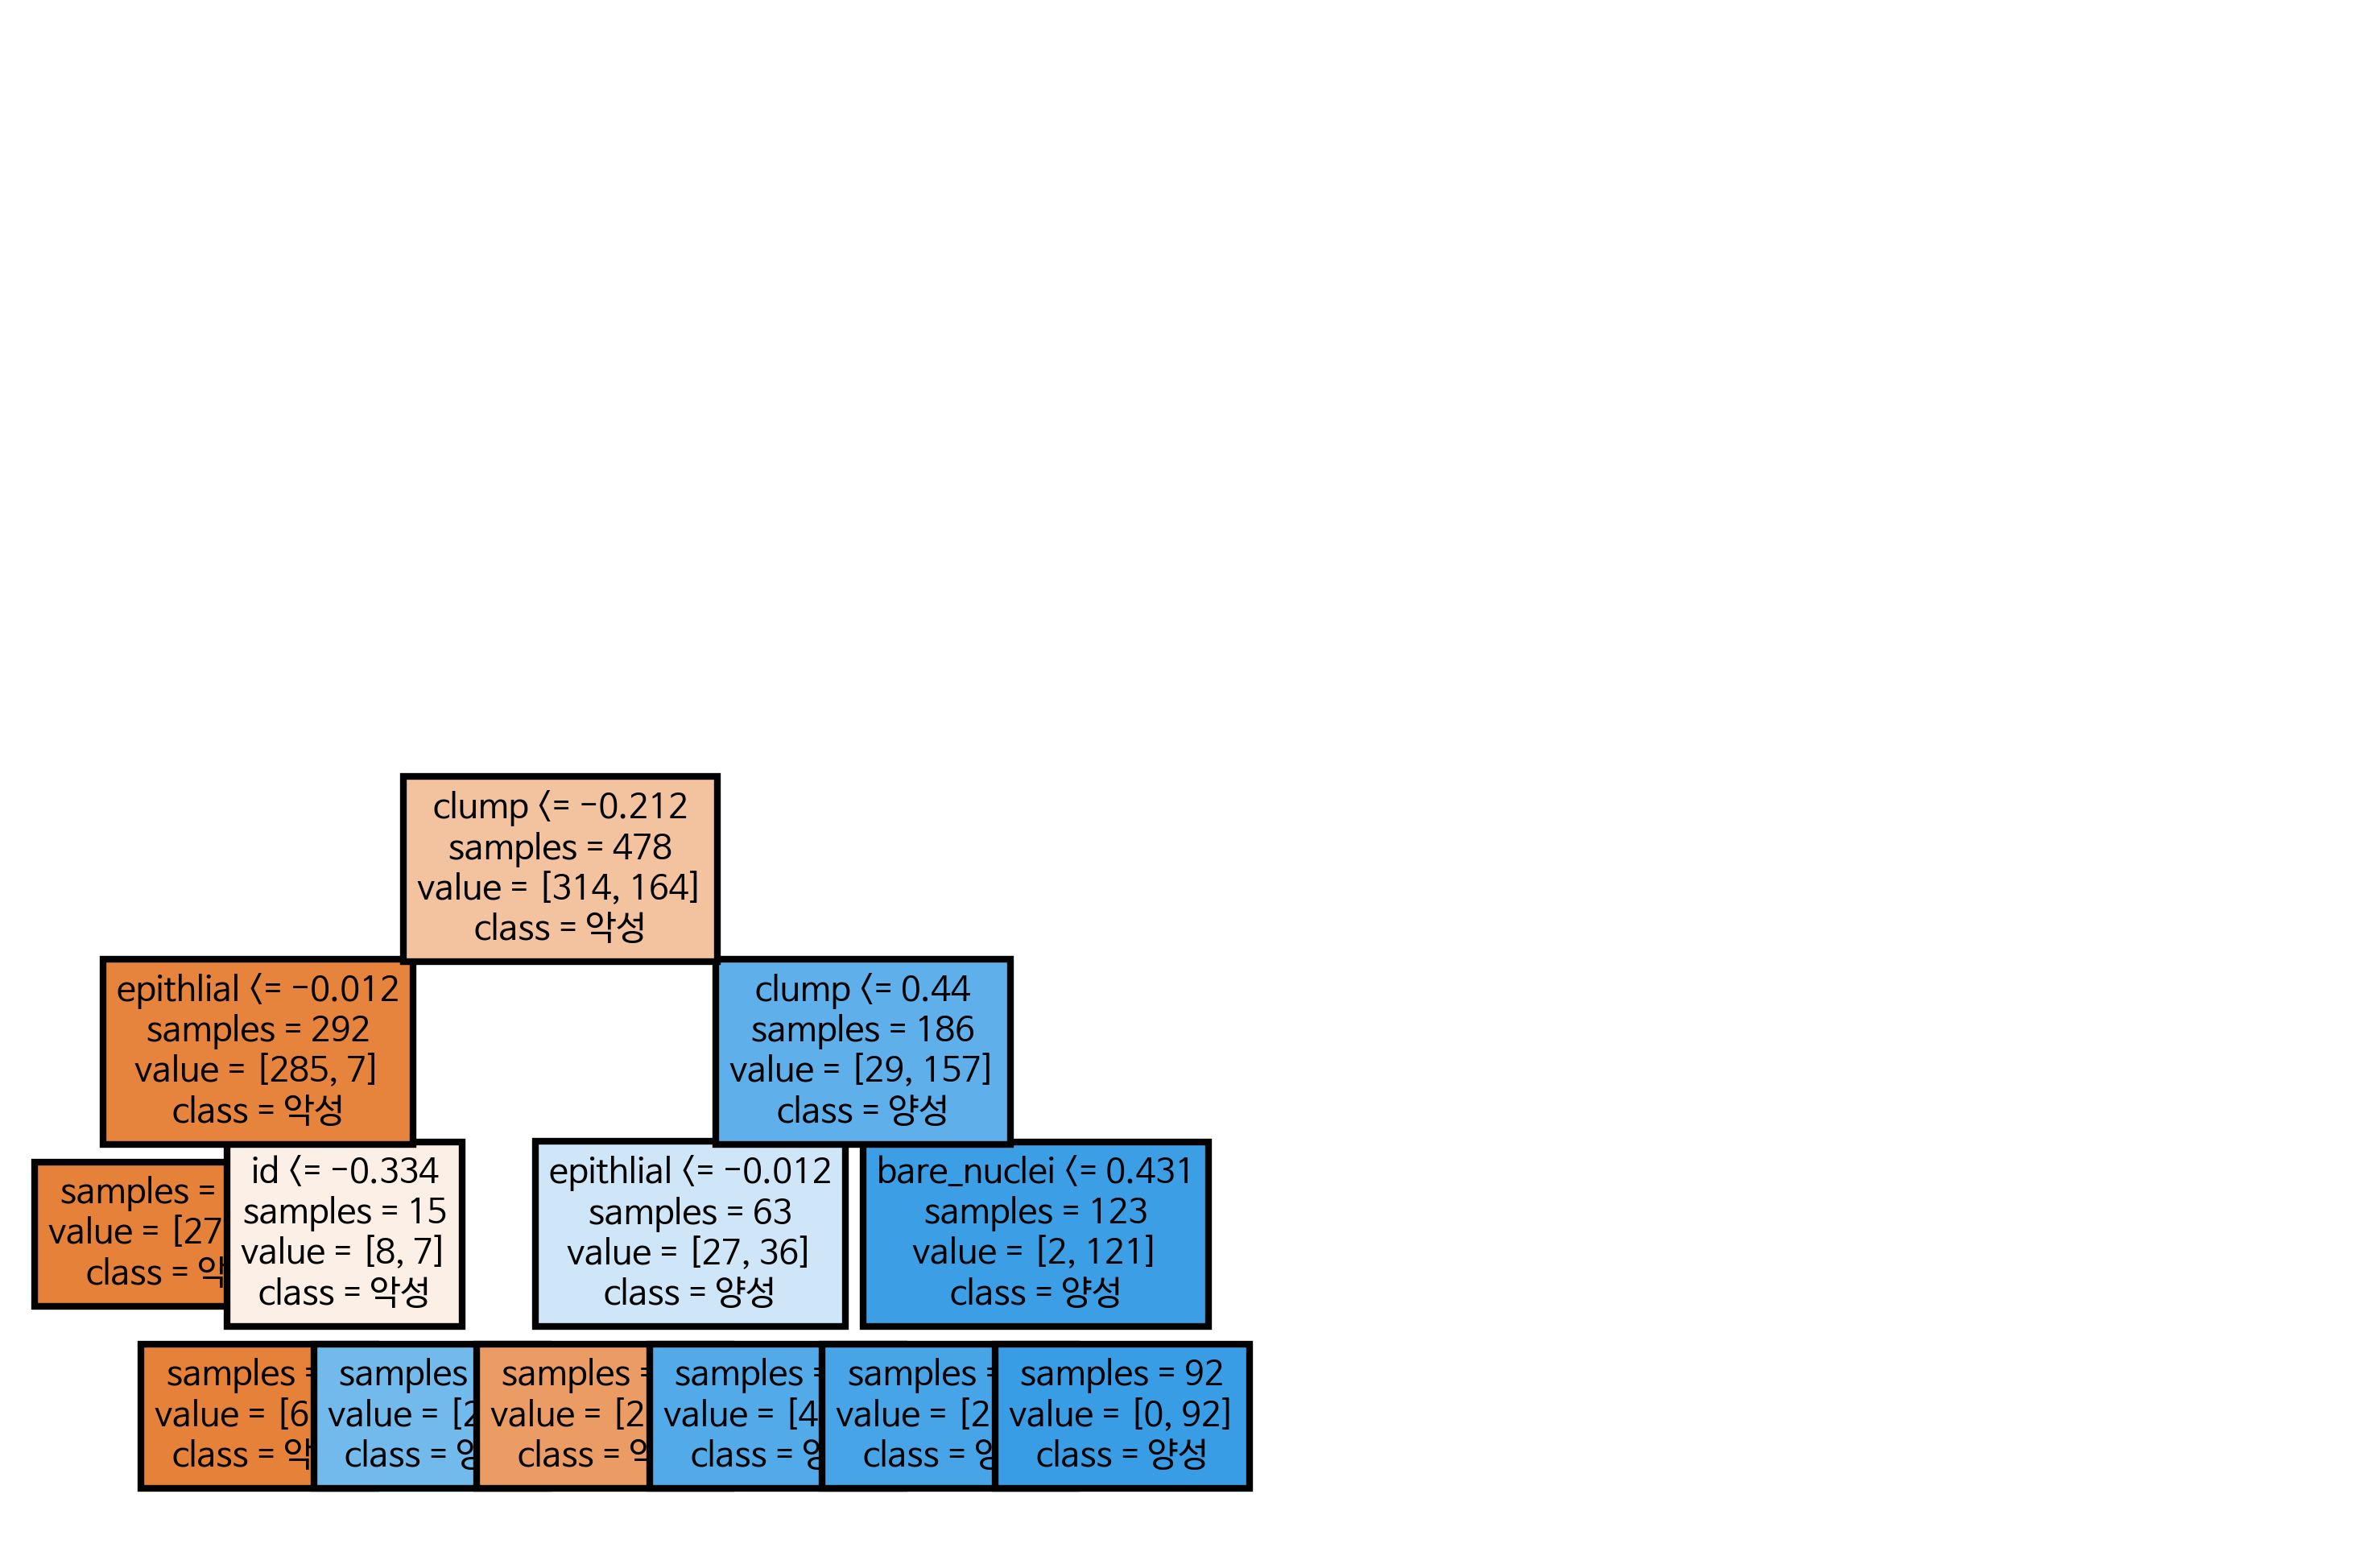

In [32]:
from sklearn.tree import plot_tree

plt.figure(dpi=300)
plot_tree(tree_model, class_names=['악성', '양성'],
          feature_names = df.columns, impurity=False, filled=True)
plt.show()

In [33]:
from sklearn.tree import export_graphviz
export_graphviz(tree_model, out_file = 'tree.dot', class_names=['악성', '양성'],
                feature_names=df.columns[1:10], impurity=False, filled=True)

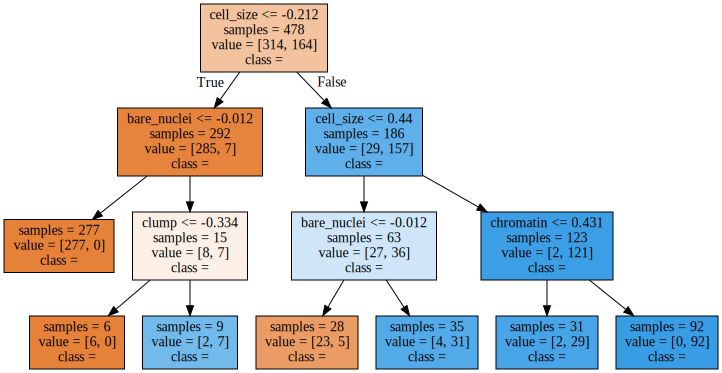

In [34]:
import graphviz

with open('tree.dot') as f:
  dot_graph = f.read()
display(graphviz.Source(dot_graph))

최적의 max_depth 설정하기

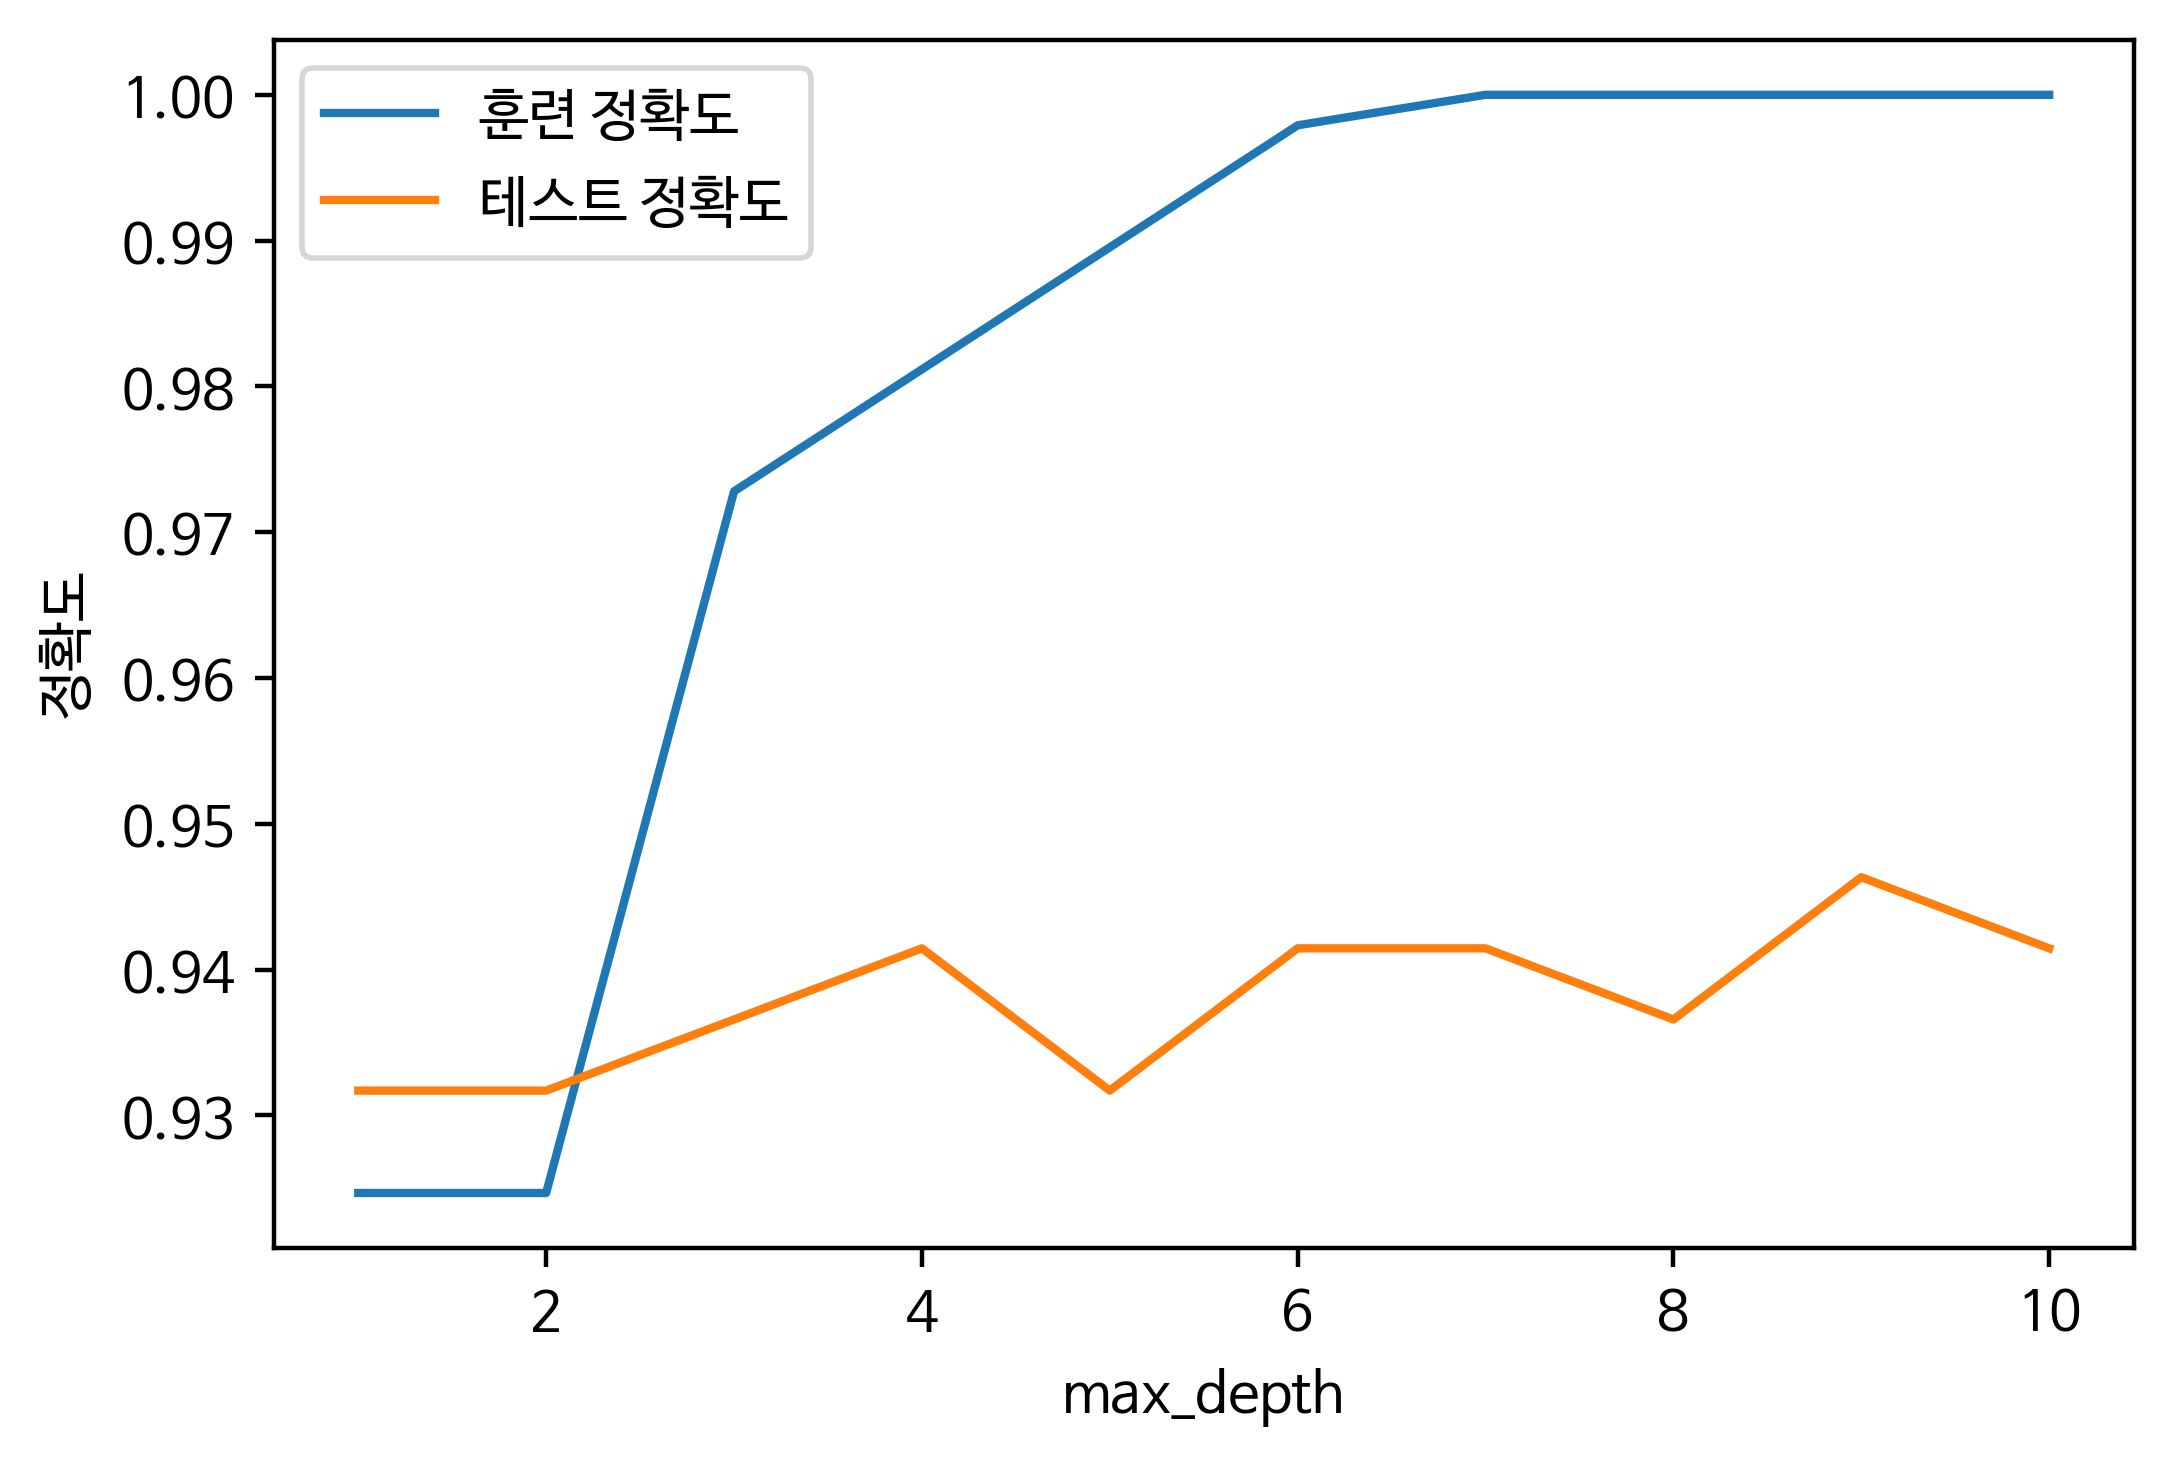

In [35]:
training_accuracy = []
test_accuracy = []
# 1 에서 10 까지 max_depth 를 적용
max_depth_settings = range(1, 11)

for max_depth in max_depth_settings:
    # 모델 생성
    tr = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    tr.fit(X_train, y_train)
    # 훈련 세트 정확도 저장
    training_accuracy.append(tr.score(X_train, y_train))
    # 테스트 세트(일반화) 정확도 저장
    test_accuracy.append(tr.score(X_test, y_test))

plt.figure(dpi = 200)
plt.rc('font', family ='NanumBarunGothic')

plt.plot(max_depth_settings, training_accuracy, label="훈련 정확도")
plt.plot(max_depth_settings, test_accuracy, label="테스트 정확도")
plt.ylabel("정확도")
plt.xlabel("max_depth")
plt.legend()
plt.show()
